In [1]:
# Load Extension for noTeXbook theme
%load_ext notexbook

In [2]:
# Enable noTeXbook theme
%texify --linespread 1.5 --code-font Monaco

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/pytorch-beautiful-ml-data/pydata-global/?filepath=2_torch_dataset/dataset_and_torch.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/2_torch_dataset/dataset_and_torch.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/2_torch_dataset/dataset_and_torch.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. <br />
Please **Trust** the notebook to automatically enable the theme. If you are viewing this notebook in **Google Colab**, these are the [instructions](https://github.com/leriomaggio/notexbook-jupyter-theme/tree/texbook-colab) to enable the theme in Colab.</span>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Zen-of-Data-Abstractions" data-toc-modified-id="The-Zen-of-Data-Abstractions-1">The Zen of Data Abstractions</a></span></li><li><span><a href="#Data-Model-for-Deep-Learning" data-toc-modified-id="Data-Model-for-Deep-Learning-2">Data Model for Deep Learning</a></span><ul class="toc-item"><li><span><a href="#From-Bunch-to-Dataset" data-toc-modified-id="From-Bunch-to-Dataset-2.1">From <code>Bunch</code> to <code>Dataset</code></a></span></li></ul></li><li><span><a href="#Case-Study:-Facial-Emotion-Recognition" data-toc-modified-id="Case-Study:-Facial-Emotion-Recognition-3">Case Study: <code>Facial Emotion Recognition</code></a></span><ul class="toc-item"><li><span><a href="#The-Facial-Emotion-Recognition-Dataset" data-toc-modified-id="The-Facial-Emotion-Recognition-Dataset-3.1">The Facial Emotion Recognition Dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-3.1.0.1">Data Description</a></span></li><li><span><a href="#Credits" data-toc-modified-id="Credits-3.1.0.2">Credits</a></span></li></ul></li></ul></li><li><span><a href="#1.-Downloading-the-Data" data-toc-modified-id="1.-Downloading-the-Data-3.2">1. Downloading the Data</a></span></li><li><span><a href="#2.-Processing-raw-data-using-pandas" data-toc-modified-id="2.-Processing-raw-data-using-pandas-3.3">2. Processing <code>raw</code> data using <code>pandas</code></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Before-moving-on..." data-toc-modified-id="Before-moving-on...-3.3.0.1">Before moving on...</a></span></li></ul></li></ul></li><li><span><a href="#3.-Creating-FERDataset" data-toc-modified-id="3.-Creating-FERDataset-3.4">3. Creating <code>FERDataset</code></a></span></li><li><span><a href="#Iteration-Time" data-toc-modified-id="Iteration-Time-3.5">Iteration Time</a></span></li></ul></li><li><span><a href="#Case-Study:-Sentiment140" data-toc-modified-id="Case-Study:-Sentiment140-4">Case Study: <code>Sentiment140</code></a></span></li><li><span><a href="#References-and-Futher-Reading:" data-toc-modified-id="References-and-Futher-Reading:-5">References and Futher Reading:</a></span></li></ul></div>

# `Dataset` and PyTorch

As it is customary in Machine Learning, a generic dataset is always denoted by the **feature matrix** $X$, of size $N_{samples} \times D_{features}$. 
Despite its simplicity, this *conceptual model* represents the foundation on which Machine learning (`ML`), and **Deep Learning** (`DL`) applications builds on. 

In Python, the most *obvious* implementation of this model would be using **NumPy** `ndarray`: 

1. The matrix $X$ is a `ndarray` object;
    - Also `scipy.sparse.csr` in case of sparse data;
    - 1st `axis` of `X` corresponds to `sample` dimension; 2nd axis to `features`
3. (_Supervised learning settings_) the vector $y$ of target labels would be `ndarray` object;
4. Each ML model (i.e. `sklearn.Estimator` object) expects in input `X` and `y` as `ndarray`
    - or `array-like`, to be more precise

```python
>>> estimator = Estimator(*model_params)  # generic sklearn Estimator object
>>> estimator.fit(X, y)
```

**It is indeed that simple!**

If we now try to adapt this _pseudocode_ into a more _Pytorch-alike_ syntax for deep learning:

1. `numpy.ndarray` $\mapsto$ `torch.Tensor`

```python
>>> X, y = torch.from_numpy(X), torch.from_numpy(y)
```

2. `models` are `Callable` objects in PyTorch, so no `.fit` method is required:

```python
>>> model = EstimatorNN(*params)
>>> model(X)  # X represents the whole dataset
```

So, this model _still applies_ to DL, as it also works *in practice*: the input of any PyTorch `Module` is (*at least, ed.*) a `torch.Tensor` `X` of size `samples` $\times$ `features`[$^{1}$](#fn1)

However, you would hardly see any example even remotely resembling that piece of (pseudo-)code, and the reasons for this are many!

In this notebook, we will be working on how to *encapsulate* a (generic) dataset into proper **OOP** abstractions that would either (**A**) fit perfectly into the [Python Data Model](https://docs.python.org/3/reference/datamodel.html); (**B**) provide flexible and 
easy-to-use data types that serves any specific requirement for the training of Deep neural networks.





<span id="fn1"><i>[1]: </i>Regardless of how many dimensions `features` may have.</span>

## The Zen of Data Abstractions

The general _mantra_ that we will try to support in this tutorial is:

- Data does **never** come *already* pre-processed (🚫 `MNIST`)
    - either in `features` or in `partitions`

- A dataset for DL is (and requires) more than `numpy.ndarray` $\mapsto$ `torch.Tensor`[$^{\star}$](#fnstar2)
    - same applies to `pandas.DataFrame` $\mapsto$ `torch.Tensor`

- Data Science 💙 OOP

- *good* OOP abstractions make your life a lot easier
    - and are also a lot of fun to use!
    
- FYI: **Python Data Model** rocks 🚀

I called this the *Zen of Data Abstractions* (for _deep learning_).

*Note*: I did come up with this *name* while working at this tutorial...so I presume the list is still _incomplete_ and would benefit for some revisions. 
*If only* the **Global PyData Community** would be gathered into a unique conference...

<span id="fnstar2"><i>[$^{\star}$]: </i>Although there exists an instance of `torch.utils.data.TensorDataset` 😊</span>


## Data Model for Deep Learning

In the introductory **Prelude** of this tutorial we focused on how to _represent_ data for ML algorithms. In particular, we discussed what is required to fit a generic dataset into the `samples x features` representation expected by ML/DL models. 

We also emphasized that this model also fits perfectly into the **Deep Learning** context, without any loss of generality. This is true in general, however **training** Deep Neural Networks (`DNN`) imposes new unprecedented requirements that we must consider.
The _core training algorithm_ of a (`feed-forward`) DNN is indeed very simple.

The whole process comprises **two** main phases, which are iterated up to a total number of times (i.e. `epochs`): <br /> (1) the `forward` pass (`left` $\rightarrow$ `right`); (2) the `backward` pass (`left` $\leftarrow$ `right`).

- [`Forward`]: The model gets the `inputs` data, and `outputs` are generated, based on current model parameters (i.e. `weights`);
- [`Backward`]: Errors (`loss`) are calculated, and `weights` are updated to _minimise_ these errors (following the opposite direction of the gradient, i.e. _Gradient Descent_);
- `repeat until` a max number of iterations has been performed. 


![learning_loop](./learning_process.png)

<span class="fn"><i>Source: </i> [Deep Learning with PyTorch](https://pytorch.org/deep-learning-with-pytorch)</span>

In addition, we would need to have:

- input data as organised in (*shuffled*) `mini-batches`
    - this aids optimisation;
    - this complies with memory constratints imposed by GPU architectures;
- a single training `epoch` as partitioned into the training of all the `batches` (one batch at a time)

In a *Pytorch-alike* pseudocode (*not much different from the real one, ed.*), the training algorithm would be:

```python
for epoch in range(NUM_EPOCHS):
    for batch in iter(dataset, no_replacement, shuffle=True):
        X, y_true = batch               # batch is a tuple (samples, labels)
        optimizer.zero_grad()           # zero the gradient of the optimizer
        y_hat = model(batch)            # forward pass
        loss = criterion(y_hat, y_true) # calculate errors
        loss.backward()                 # backward pass
        optimizer.step()                # optimisation step
```

So, we need a `Dataset` abstraction that it is **subscriptable** (e.g. `dataset[i]`, or 
`dataset[batch_start:batch_end]`), and **iterable**. 

In particular, the iteration protocol should be flexible enough to adapt to different requirements, e.g. *shuffling* is required or not, sampling *with* or *without* replacement.
In these circumstances, we would presumably need a different `object` to just deal with this iteration protocol for a given input `dataset`. 

**Last but not least**: <ins>*Data Augmentation*</ins> should be also be considered as an extra (DL-specific) requirement. Our abstraction should easily allow to include data augmentantion easily. 

### From `Bunch` to `Dataset`

If we are transitioning from `sklearn` (ML) to `torch` (DL), we are very used to think of our ML data in terms of `numpy` arrays (and other supported variants, i.e. `scipy.sparse.csr` or `pandas.DataFrame`).

However, it is now clear that we need something more.

`sklearn` indeed has its own general [`dataset` API](https://scikit-learn.org/stable/datasets/index.html#general-dataset-api) whenever a new dataset is loaded:

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()

print(type(iris))

<class 'sklearn.utils.Bunch'>


In [4]:
from sklearn.utils import Bunch

Bunch?

A `sklearn.utils.Bunch` object is a class that maps dictionary keys into class fields (*brilliant, ed.*):

In [5]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [6]:
X = iris.data  # same as iris["data"]

This is definitely a first step towards a more OOP-oriented data encapsulation, and *metadata* are handled brilliantly with this abstraction. However, we still need a more flexible strategy to handle data *in-memory*:

`torch.utils.data.Dataset` is an abstract class representing a dataset in `torch`. 

Any custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support a dataset which is **subscriptable** for sample indexing, or batch slicing. 

**Just simple as that** !

---

## Case Study: `Facial Emotion Recognition`

Let's finally workout our first case **full** case study, working on the `FER` (Facial Emotion Recognition) dataset. 

This dataset is interesting at so many level, and it will be used here, and in next part as reference example.

In **this** notebook, we will start from the very beginning, working our way towards our own `FERDataset` abstraction starting from **downloading** the dataset, and quickly preprocessing in its *raw* form.

### The Facial Emotion Recognition Dataset 

The `FER` dataset is a publicly [available](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset, released on **Kaggle** for the **Challenges in Representation Learning: Facial Expression Recognition Challenge**.

The goal of the challenge is to identify emotions from images of facial expressions.

**Reference**:

> *Challenges in Representation Learning: A report on three machine learning
contests.* 
>
> I Goodfellow, D Erhan, PL Carrier, A Courville, M Mirza, B
Hamner, W Cukierski, Y Tang, DH Lee, Y Zhou, C Ramaiah, F Feng, R Li,
X Wang, D Athanasakis, J Shawe-Taylor, M Milakov, J Park, R Ionescu,
M Popescu, C Grozea, J Bergstra, J Xie, L Romaszko, B Xu, Z Chuang, and
Y. Bengio. arXiv 2013.

##### Data Description

(adapted from [page](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) on Kaggle)

> The data consists of `48` $\times$ `48` pixel grayscale images of faces. 
> The faces have been automatically registered so that the face is more or less centered, 
> and occupies about the same amount of space in each image. 
> The task is to categorize each face based on the emotion shown in the facial expression
> into one of seven categories:
> (`0=Angry`, `1=Disgust`, `2=Fear`, `3=Happy`, `4=Sad`, `5=Surprise`, `6=Neutral`).


> The training set consists of `28,709` examples, validation set consists of `3,589` examples. The 
> final test set, also consists of another `3,589` examples.

##### Credits

>This dataset was prepared by Pierre-Luc Carrier and Aaron Courville, as part of an ongoing research project. They have graciously provided the workshop organizers with a preliminary version of their dataset to use for this contest.

**What's the plan, then?**

Well, the plan now is to work out the different bits we would need to encapsulate as `methods` of our `FERDataset` class to load and *preprocess* data. 

In particular, we are aiming to:
1. enable automatic download of the original `data`;
2. preprocess data from its original `raw` format (CSV)
3. transform data (per each partition) into `torch.Tensor`
4. **save** these tensors for later re-use, avoiding to repeat the previous steps at all!

### 1. Downloading the Data

The dataset is available on Kaggle, and mirrored by me on [this](https://www.dropbox.com/s/2rehtpc6b5mj9y3/fer2013.tar.gz?dl=1) Dropbox link in its original form.

To automatically download the data, we will be using the `download_and_extract_archive` utility function included in the `torchvision.datasets.utils` module[$^{2}$](#fn2).

<span id="fn2"><i>[2]: </i> This function is used in **all** the `VisionDataset` instances included in `torchvision.datasets` classes.</span>

In [7]:
from pathlib import Path
from torchvision.datasets.utils import download_and_extract_archive

In [8]:
FER_URL = "https://www.dropbox.com/s/2rehtpc6b5mj9y3/fer2013.tar.gz?dl=1"
DOWNLOAD_ROOT = Path(".")
FILENAME = "fer2013.tar.gz"
MD5 = "ca95d94fe42f6ce65aaae694d18c628a"

In [9]:
download_and_extract_archive(url=FER_URL, download_root=DOWNLOAD_ROOT, filename=FILENAME, md5=MD5)

Extracting ./fer2013.tar.gz to .


In [10]:
!ls ./fer2013/

README      fer2013.bib fer2013.csv


### 2. Processing `raw` data using `pandas`

In [11]:
import pandas as pd 

In [12]:
FER_CSV_PATH = Path("./fer2013/") / "fer2013.csv"

fer_df = pd.read_csv(FER_CSV_PATH, header=0, names=["emotion", "pixels", "partition"])

In [13]:
fer_df.shape

(35887, 3)

In [14]:
fer_df.columns

Index(['emotion', 'pixels', 'partition'], dtype='object')

In [15]:
fer_df.head()

,emotion,pixels,partition
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


The structure of the data looks quite simple: 

1. As documented, image `pixels` are reported _flattened_ into each row;
2. Emotions are encoded as numbers, and presumably we should make it a categorical variable
3. The `Usage` column assign a dataset partition to each sample

In [16]:
fer_df.partition.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

Let's remap partitions' names into a more standard _nomenclature_

In [17]:
fer_df.partition = fer_df.partition.apply(lambda v: 
                                          'training' if v == 'Training' else 'validation' 
                                          if v == 'PrivateTest' else 'test')

In [18]:
fer_df.partition.unique()

array(['training', 'test', 'validation'], dtype=object)

In [19]:
fer_df.partition.value_counts()

training      28709
validation     3589
test           3589
Name: partition, dtype: int64

**Emotion** labels encoding:

In [20]:
EMOTION_MAP = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

fer_df.emotion = pd.Categorical(fer_df.emotion)
fer_df["emotion_label"] = fer_df.emotion.apply(lambda c: EMOTION_MAP[c])

In [21]:
fer_df.emotion.cat.codes.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int8)

In [22]:
fer_df.emotion_label.values.unique()

['Angry', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprise', 'Disgust']
Categories (7, object): ['Angry', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprise', 'Disgust']

Now let's try to plot an image loading its pixels from the `DataFrame`.

We will be using the `fromstring` function of `numpy` to convert a string of digits into a `ndarray` object.

In [23]:
from matplotlib import pyplot as plt
import numpy as np

In [24]:
pixels = fer_df.iloc[0].pixels
img = np.fromstring(pixels, dtype=np.uint8, sep=" ")
print(img.shape)

(2304,)


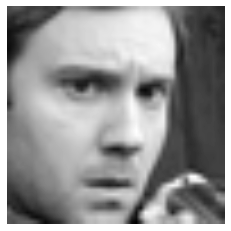

In [25]:
plt.imshow(img.reshape(48, 48), cmap="gray", interpolation='bilinear')
plt.axis("off")
plt.show()

Here are `100` random samples at a first glance

In [26]:
from functools import partial 

# shortcut for plt.text with some settings
text_annotation = partial(plt.text, x=36, y=46, fontdict={'color': 'red', 'fontsize': 10, 'ha': 'center', 
                                                          'va': 'center', 
                                                          'bbox': dict(boxstyle="round", fc="white", 
                                                                       ec="black", pad=0.2)})

def overview(samples):
    """
    The function is used to plot first 
    several pictures for overviewing 
    image dataset.
    """
    fig = plt.figure(figsize=(25,25))
    image_shape = (48, 48)
    for i, (em_label, bytestring) in enumerate(samples):
        ax = fig.add_subplot(10,10,i+1)
        comp = np.fromstring(bytestring, dtype=np.uint8, sep=' ')
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='bilinear',
                   vmin=-vmax, vmax=vmax)
        text_annotation(s='{}-{}'.format(str(i+1).zfill(2), em_label))
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

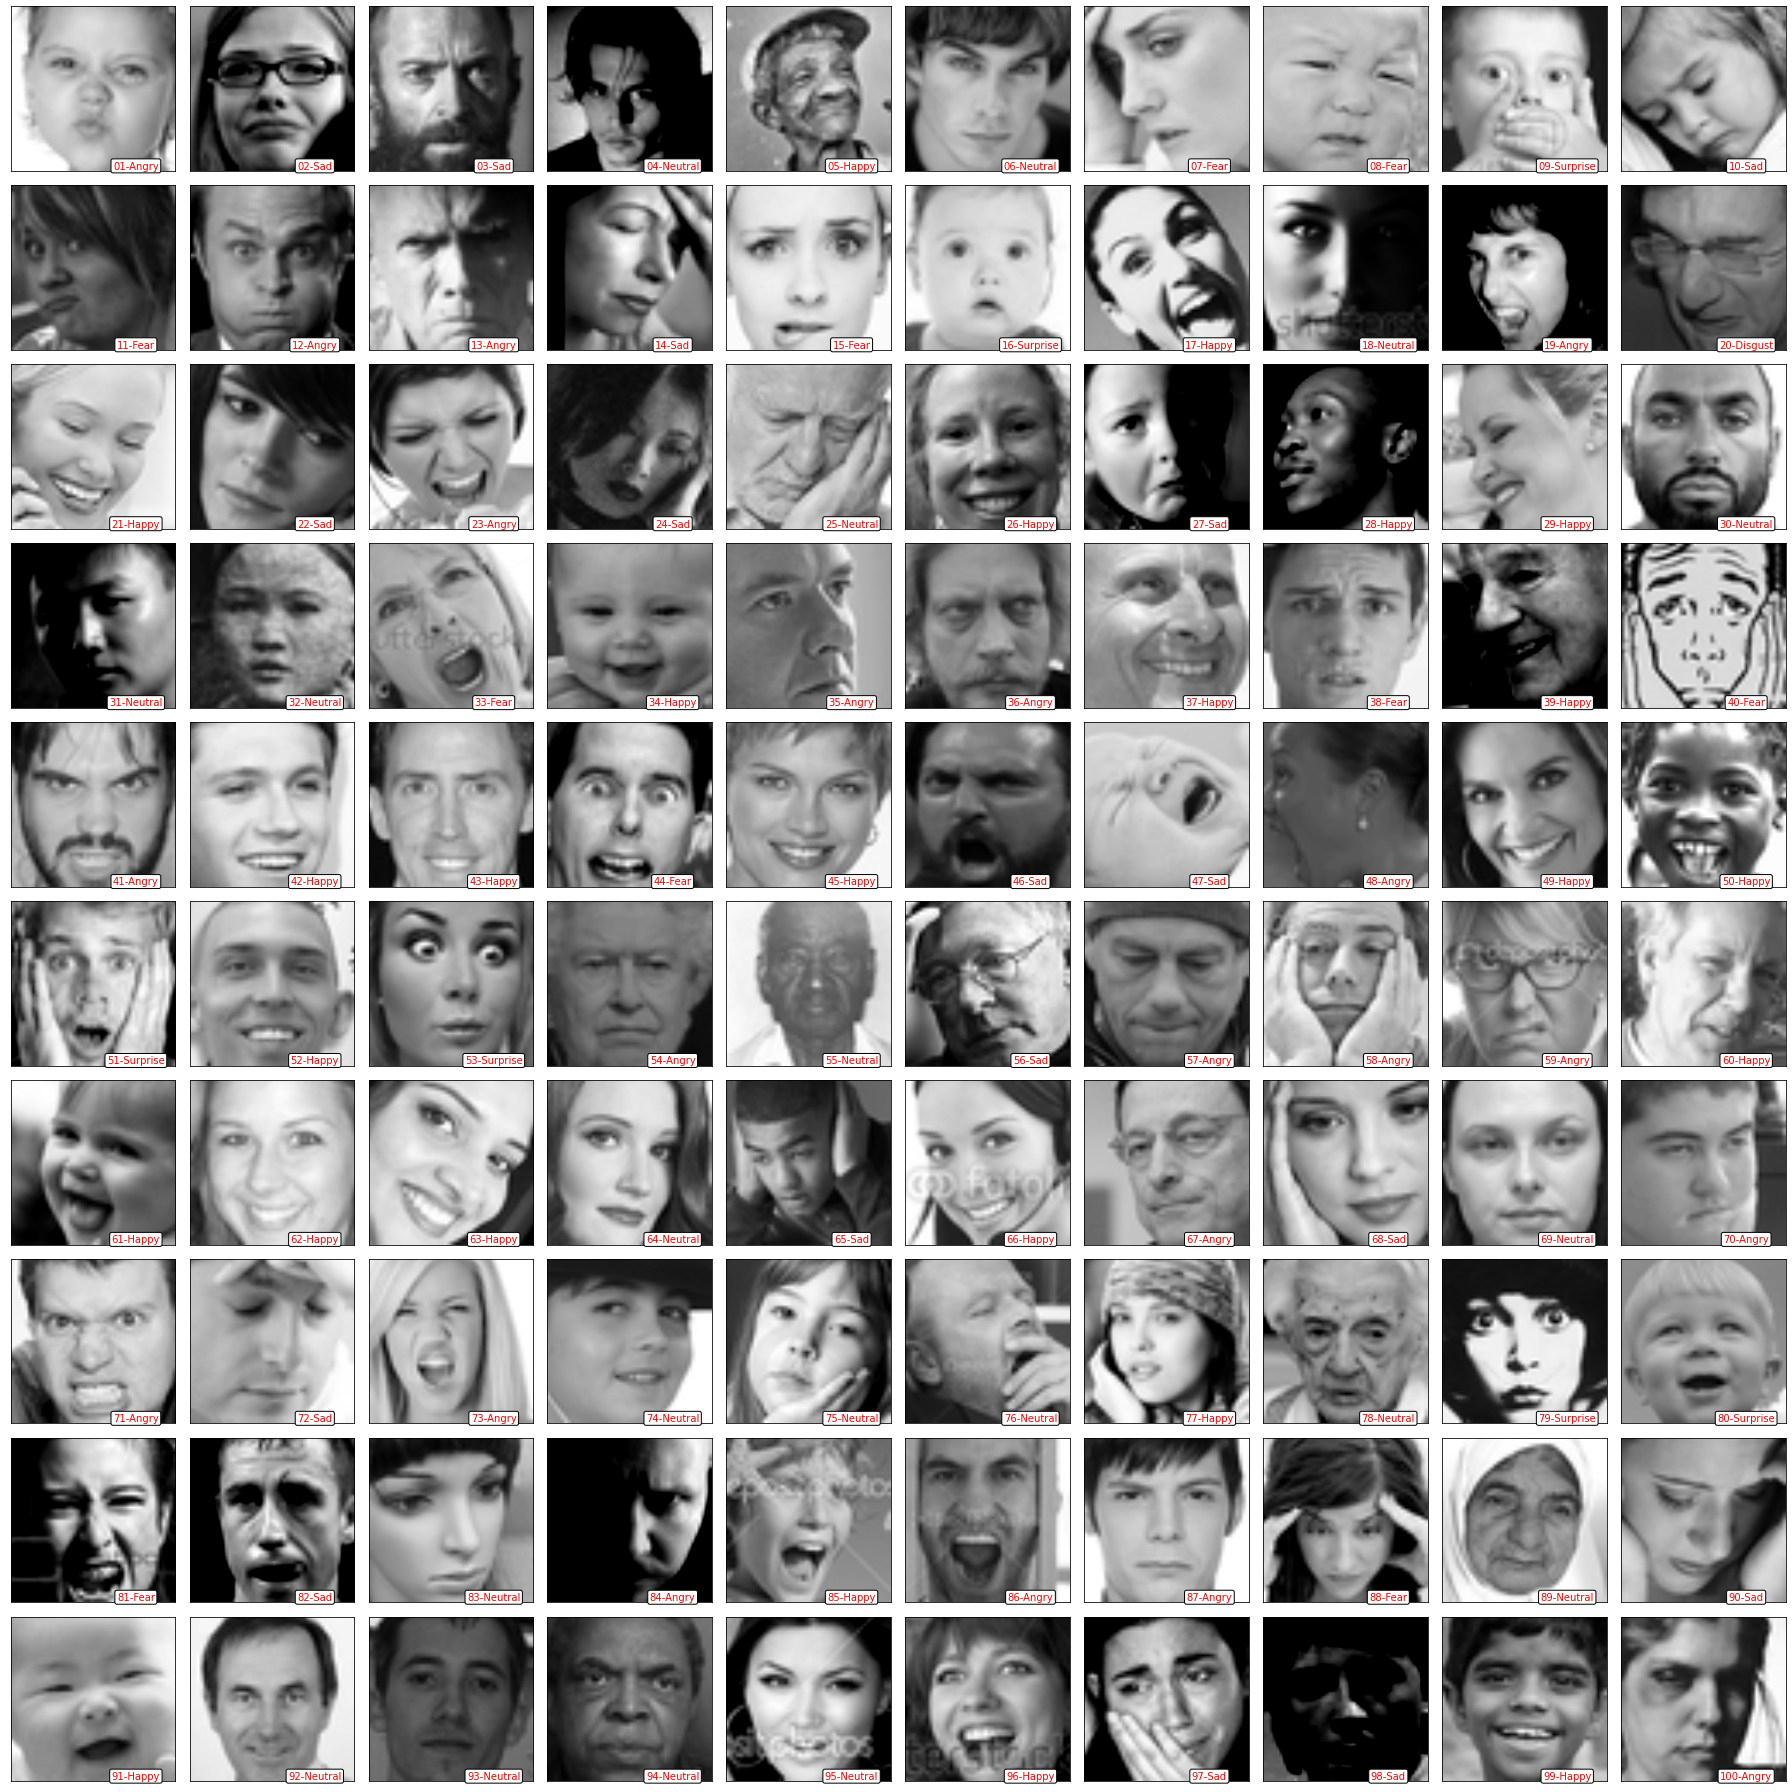

In [27]:
SEED = 920  # 0b1110011000
samples = fer_df.sample(n=100, random_state=SEED, replace=False)
overview(samples[["emotion_label", "pixels"]].values)  # this may take a bit to render

##### Before moving on...

The **last** and quite important bit it is left to consider is how samples are distributed among the three given partitions, per each single `emotion` label.

In other words, we want to investigate **samples per-class distribution**.

Even if this is not necessary for the `Dataset` abstraction per se, it is always a very good idea to explore how imbalanced a dataset can be, in order to be ready to put _remedies_ in place.

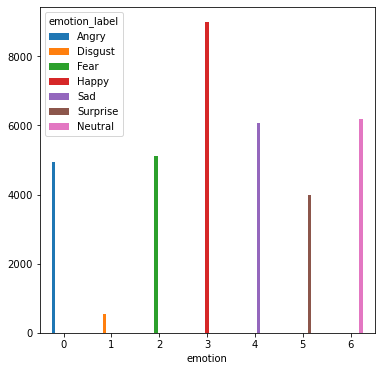

In [28]:
fer_df.groupby("emotion").emotion_label.value_counts().unstack().plot(kind="bar", rot=0,
                                                                      figsize=(6, 6))
plt.show()

⚠️ As we can see, this dataset is quite imbalanced towards `happy`, `sad`, and `neutral` emotions, with the `disgust` being the least represented class (by a lot).

To further investigate how this reflects to corresponding **given**[$^{\star}$](#fnstar) data partitions: 


<span id="fnstar"><i>[$\star$]: </i>Please bear in mind that this dataset comes from a Kaggle challenge, therefore original partitioning might intentionally include some bias of any sort induced by the very nature of the challenge itself.</span>

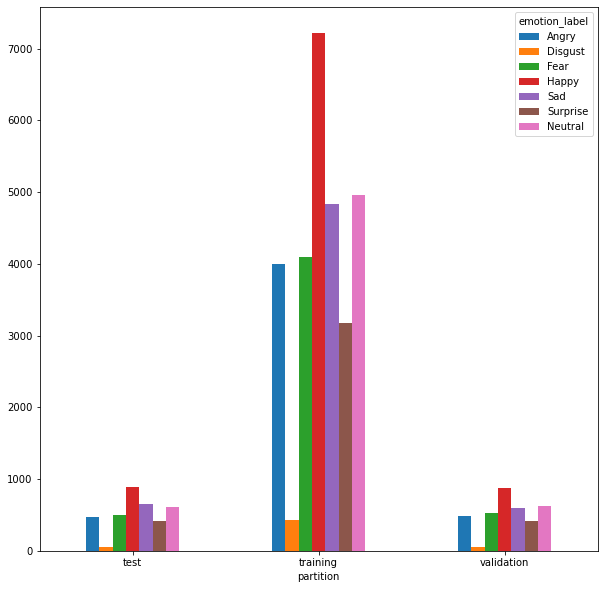

In [29]:
fer_df.groupby('partition').emotion_label.value_counts().unstack().plot(kind="bar", rot=0,
                                                                        figsize=(10, 10))
plt.show()

From this **plot** we can conclude that this samples distribution in `test` and `validation` is somewhat comparable, if not identical. Nothing we can say on the actual selected samples, yet.

### 3. Creating `FERDataset`

We are finally ready to encapsulate all the previous steps into a custom `torch.utils.data.Dataset` class

⚠️ **NOTE**

For the sake of this notebook, the `Dataset` class will be directly into a single cell for the sole sake of keeping it all together here, and to narrative, and explanations.

For this reason, also **comments** and *code documentation* will be slightly reduced to the bare minimum here. 

The complete and documented `fer.py` module will be used and re-used in future notebooks, also to avoid useless repetitions, and difficult-to-read//maintain notebook cells :)

In [30]:
import os
from math import sqrt
from typing import Tuple

import torch
from torch.utils.data import Dataset
from PIL import Image

In [31]:
class FER(Dataset):
    RAW_DATA_FILE = "fer2013.csv"  # input original CSV filename
    RAW_DATA_FOLDER = "fer2013"  # original data folder name
    resources = [("https://www.dropbox.com/s/2rehtpc6b5mj9y3/fer2013.tar.gz?dl=1",
                  "ca95d94fe42f6ce65aaae694d18c628a",)]
    # torch Tensor filename
    data_files = { "train": "training.pt", "validation": "validation.pt", "test": "test.pt",}
    # classes list
    classes = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral",]

    def __init__(self, root: str, split: str = "train", download: bool = False):
        self.root = root
        split = split.strip().lower()
        if split not in self.data_files:
            raise ValueError(
                "Data Partition not recognised. Accepted values are 'train', 'validation', 'test'."
            )
        if download:
            self.download()  # download, preprocess, and store FER data
        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found." + " You can use download=True to download it"
            )
        self.split = split
        data_file = self.data_files[self.split]
        data_filepath = self.processed_folder / data_file
        # load serialisation of dataset as torch.Tensors
        self.data, self.targets = torch.load(data_filepath)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img, target = self.data[index], int(self.targets[index])
        img = torch.unsqueeze(img, 0)
        return img, target
    
    def _check_exists(self):
        for data_fname in self.data_files.values():
            data_file = self.processed_folder / data_fname
            if not data_file.exists():
                return False
        return True

    def download(self):
        """Download the FER data if it doesn't already exist in the processed folder"""
        if self._check_exists():
            return
        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)
        # download files
        for url, md5 in self.resources:
            filename = url.rpartition("/")[-1].split("?")[0]
            download_and_extract_archive(
                url, download_root=self.raw_folder, filename=filename, md5=md5)
        # process and save as torch files
        # process and save as torch files
        def _set_partition(label: str) -> str:
            if label == "Training":
                return "train"
            if label == "PrivateTest":
                return "validation"
            return "test"
        
        print("Processing...", end="")
        raw_data_filepath = self.raw_folder / self.RAW_DATA_FOLDER / self.RAW_DATA_FILE
        fer_df = pd.read_csv(raw_data_filepath, header=0, 
                             names=["emotion", "pixels", "partition"])
        fer_df["partition"] = fer_df.partition.apply(_set_partition)
        fer_df.emotion = pd.Categorical(fer_df.emotion)
        for partition in ("train", "validation", "test"):
            dataset = fer_df[fer_df["partition"] == partition]
            images = self._images_as_torch_tensors(dataset)
            labels = self._labels_as_torch_tensors(dataset)
            data_file = self.processed_folder / self.data_files[partition]
            with open(data_file, "wb") as f:
                torch.save((images, labels), f)
        print("Done!")

    def _images_as_torch_tensors(self, dataset: pd.DataFrame) -> torch.Tensor:
        """
        Extract all the pixel from the input dataframes, and convert images in
        a [sample x features] torch.Tensor
        """
        imgs_np = (dataset.pixels.map(self._to_numpy)).values
        imgs_np = np.concatenate(imgs_np, axis=0)
        samples_no, pixels = imgs_np.shape
        new_shape = (samples_no, int(sqrt(pixels)), int(sqrt(pixels)))
        return torch.from_numpy(imgs_np).view(new_shape)

    @staticmethod
    def _labels_as_torch_tensors(dataset: pd.DataFrame) -> torch.Tensor:
        """Extract labels from pd.Series and convert into torch.Tensor"""
        labels_np = dataset.emotion.values.astype(np.int)
        return torch.from_numpy(labels_np)

    @staticmethod
    def _to_numpy(pixels: str) -> np.ndarray:
        """Convert one-line string pixels into NumPy array, adding the first
        extra axis (sample dimension) later used as the concatenation axis"""
        img_array = np.fromstring(pixels, dtype=np.uint8, sep=" ")[np.newaxis, ...]
        return img_array
    
    @property
    def processed_folder(self):
        return Path(self.root) / self.__class__.__name__ / "processed"

    @property
    def raw_folder(self):
        return Path(self.root) / self.__class__.__name__ / "raw"
    
    @property
    def idx_to_class(self):
        return {i: _class for i, _class in enumerate(self.classes)}
    
    

In [32]:
!rm -Rf ./fer2013* # remove already downloaded data

In [33]:
fer_training = FER(root=".", download=True, split="train")

In [34]:
len(fer_training)

28709

In [35]:
img, label = fer_training[3]

In [36]:
img.shape

torch.Size([1, 48, 48])

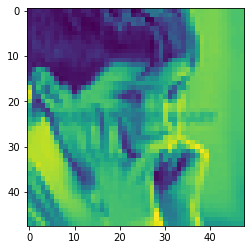

In [37]:
plt.imshow(img.numpy().transpose((1, 2, 0)))

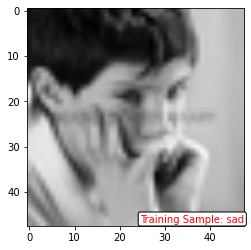

In [38]:
img, label = fer_training[3]
plt.imshow(img.numpy().transpose((1, 2, 0)), interpolation="bilinear", cmap="gray")
text_annotation(s=f"Training Sample: {fer_training.idx_to_class[label]}")
plt.show()

In [39]:
fer_validation = FER(root=".", download=True, split="validation")

In [40]:
len(fer_validation)

3589

Let's now iterate some samples from the dataset

0 torch.Size([1, 48, 48]) 0
1 torch.Size([1, 48, 48]) 5
2 torch.Size([1, 48, 48]) 6
3 torch.Size([1, 48, 48]) 4


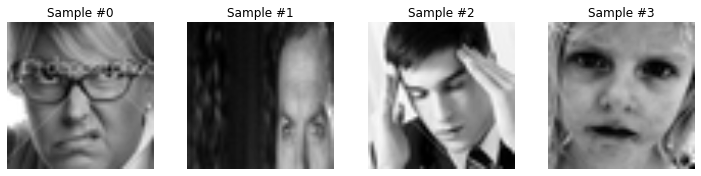

In [41]:
fig = plt.figure(figsize=(10, 10))

for i, (face, emotion) in enumerate(iter(fer_validation), start=0):
    
    print(i, f"{face.shape}", emotion)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(face.numpy().transpose((1, 2, 0)), interpolation="bilinear", cmap="gray")
    if i == 3:
        plt.show()
        break

So, the dataset is **subscriptable** as required, and we can easily `iter`-ate it to access single samples. 

However, as already anticipated, we can do a lot better... also because we need more!  And `torch` provides better abstractions to iterate over a `Dataset`: `torch.utils.data.DataLoader`!

### Iteration Time

In the previous example, we demonstrated that we can easily use a generic Python `iterator` object to iterate over samples of a `Dataset`. 

A `Dataset` object is indeed subscriptable, therefore is is always possible to do so. 

However, in doing so we would be missing out a lot of features:

- Batching the data
- Shuffling the data
- Load the data in parallel using `multiprocessing` workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. 

Parameters used below should be clear:

- `shuffle=False` whether to shuffle the samples (only required in training)
- `dataset`: the dataset to iterate
- `batch_size`: the size of each `batch`, that is: "how many samples per single batch"
- `num_workers`: how many worker processess will be used to load
- `collate_fn`

One parameter of interest is `collate_fn`, which is the function that a `Dataloader` instance calls internally to **prepare** the batches. 

The `default_collate_fn` however works fine in `90%` of the cases. For example, with our `FER` dataset instance:

1. each `__getitem__` call returns a `tuple` `(torch.Tensor[1, 48, 48], int)`

2. The `default_collate_fn` collects a `batch_size` number of those dictionaries, and stack samples together so that:
    - `batch` $\mapsto$ `[(Tensor[batch_size, 1, 48, 48]`, `Tensor[batch_size])]`
 

In [42]:
from torch.utils.data import DataLoader

In [43]:
validation_loader = DataLoader(fer_validation, batch_size=4, num_workers=0, shuffle=False)

In [44]:
batch = next(iter(validation_loader))

In [45]:
type(batch)

list

In [46]:
batch[0].shape, batch[1].shape

(torch.Size([4, 1, 48, 48]), torch.Size([4]))

To **customise** our `collate_fn`, we will be wrapping the result of the `default_collate_fn` implementation into a `Batch` namedtuple, for easier fields access:

In [47]:
from collections import namedtuple

from torch.utils.data.dataloader import default_collate

Batch = namedtuple("Batch", ["samples", "emotions"])

def batch_collate_fn(batch):
    batch = default_collate(batch)
    return Batch(*batch)

validation_loader = DataLoader(fer_validation, batch_size=4, num_workers=0,
                               collate_fn=batch_collate_fn, shuffle=False)

In [48]:
batch = next(iter(validation_loader))

type(batch)

__main__.Batch

In [49]:
batch.samples.shape

torch.Size([4, 1, 48, 48])

In [50]:
batch.emotions.shape

torch.Size([4])

Finally, let's have a go with our `validation_loader` to show some batches. 

We will be using the `make_grid` function from `torchvision.utils` for quicker plotting

In [51]:
from torchvision.utils import make_grid

Emotions: ['angry', 'surprise', 'neutral', 'sad']


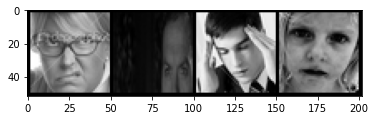

Emotions: ['fear', 'angry', 'sad', 'happy']


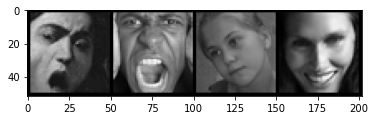

Emotions: ['angry', 'happy', 'surprise', 'happy']


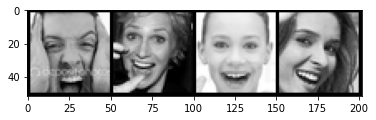

Emotions: ['sad', 'sad', 'angry', 'neutral']


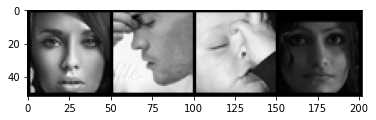

In [52]:
for i, batch in enumerate(validation_loader):
    print(f"Emotions: {list(map(lambda e: fer_validation.idx_to_class[e.item()], batch.emotions))}")
    grid = make_grid(batch.samples)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break


---

## Case Study: `Sentiment140`

Now it is time to practice with `torch` data model with another dataset. 

In [this](./case_study_sentiment140.ipynb) notebook you will find another case study that will guide you through the creation of a `Sentiment140` torch `Dataset` for **Twitter Sentiment Analysis**.

The case study is interesting for many reasons. First, it is a different data format from `FER` (i.e. text instead of images), plus it is also _Twitter_ data. So preprocessing and feature elaboration is interesting per se from a Data Science perspective. Then, it is a good opportunity to start working with text, nlp, and DL.

_Last but not least_, the approach will be always the same: step-by-step guide from the very data download up to the `Dataset` abstraction.

Hope you will have fun with it 🙌



---

## References and Futher Reading:

1. ["Deep Learning with PyTorch", by *L. Antiga et. al.*](https://www.manning.com/books/deep-learning-with-pytorch)